In [1]:
from os import makedirs
from urllib.request import urlretrieve

In [2]:
# データの取得
makedirs("data", exist_ok=True)
urlretrieve("https://git.io/vXTVC", "data/txtdata.csv")

('data/txtdata.csv', <http.client.HTTPMessage at 0x1030fa6d8>)

In [3]:
import numpy as np
import pymc as pm
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
data = np.loadtxt("data/txtdata.csv")
N = len(data)

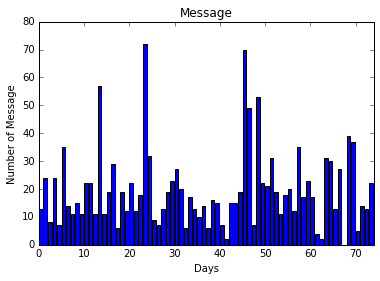

In [5]:
# データの可視化
plt.bar(np.arange(N), data, color = "b")
plt.xlabel("Days")
plt.ylabel("Number of Message")
plt.title("Message")
plt.xlim(0, N)
plt.show()

In [6]:
alpha = 1 / data.mean()

# 事前分布は指数分布
#lambda_1 = pm.Exponential("lambda_1", alpha)
#lambda_2 = pm.Exponential("lambda_2", alpha)

# 事前分布を一様分布にしてみる
lambda_1 = pm.Uniform("lambda_1", upper = (data.mean() * 2), lower = 0)
lambda_2 = pm.Uniform("lambda_2", upper = (data.mean() * 2), lower = 0)

# 変化した日にちtau
tau = pm.DiscreteUniform("tau", lower = 0, upper = N)

# ポアソン分布のパラメータ
# tau日より前はlambda_1, あとはlambda_2
lam = pm.Lambda("lam", lambda tau = tau, lambda_1 = lambda_1, lambda_2 = lambda_2: np.array([(lambda_1 if (i < tau) else lambda_2)for i in range(N)]))
# 観測結果の指定
observe = pm.Poisson("obs", lam, value = data, observed = True)

model = pm.Model([observe, lambda_1, lambda_2, tau])

mcmc = pm.MCMC()
# 50000回サンプリングして10000個捨てる, 10個づつ記録する
mcmc.sample(50000, 10000, thin=10)

 [-----------------100%-----------------] 50000 of 50000 complete in 29.7 sec

/Users/marina/.pyenv/versions/anaconda3-2.4.1/lib/python3.5/site-packages/pymc/Model.py:94: UserWarning: The MCMC() syntax is deprecated. Please pass in nodes explicitly via M = MCMC(input).
  'The MCMC() syntax is deprecated. Please pass in nodes explicitly via M = MCMC(input).')


Plotting tau
Plotting lambda_1
Plotting lambda_2


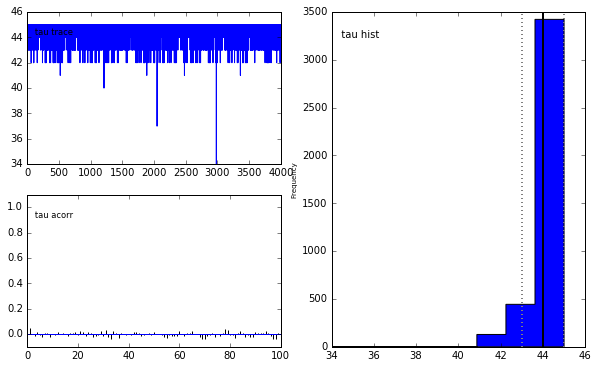

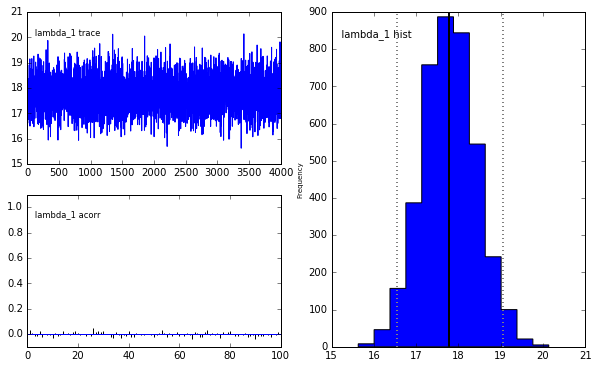

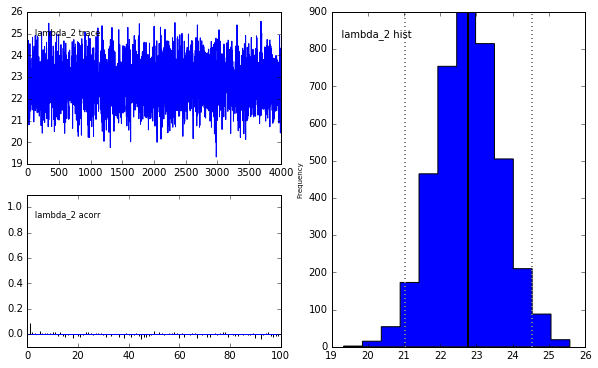

In [7]:
plt.close()
pm.Matplot.plot(mcmc.trace("tau"), common_scale=False)
pm.Matplot.plot(mcmc.trace("lambda_1"), common_scale=False)
pm.Matplot.plot(mcmc.trace("lambda_2"), common_scale=False)
plt.show()


In [8]:
print(mcmc.lambda_1.summary())
print(mcmc.lambda_2.summary())


lambda_1:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	17.788           0.64             0.01           [ 16.555  19.065]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	16.552           17.35           17.779         18.214        19.063
	
None

lambda_2:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	22.77            0.892            0.016          [ 21.024  24.542]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	21.042           22.169          22.773         23.366        24.568
	
None


/Users/marina/.pyenv/versions/anaconda3-2.4.1/lib/python3.5/site-packages/numpy/core/fromnumeric.py:224: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)


In [15]:
lambda_1_samples = mcmc.trace('lambda_1')[:] #2つのλが統計的に異なるかを確認する
lambda_2_samples = mcmc.trace('lambda_2')[:]
print(lambda_1_samples < lambda_2_samples) #lambda_1がlambda_2よりも小さければtrue
print((lambda_1_samples < lambda_2_samples).mean()) #lambda_1がlambda_2よりも小さい確率を求める

[ True  True  True ...,  True  True  True]
1.0


In [16]:
#メッセージ受信数の増加率の期待値を求める

relative_inclease_samples = \
    (lambda_2_samples - lambda_1_samples) / lambda_1_samples
print(relative_inclease_samples)

[ 0.23230913  0.35954254  0.21112351 ...,  0.35596363  0.33852499
  0.28566402]


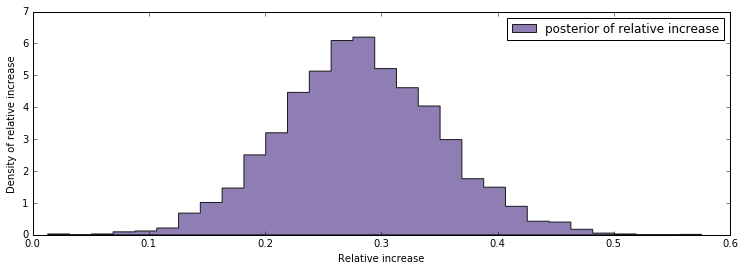

In [18]:
plt.figure(figsize=(12.5, 4))

#相対増加率の事後確率をプロット
plt.hist(relative_inclease_samples, histtype='stepfilled', bins=30, alpha=0.85, color="#7A68A6", normed=True, label='posterior of relative increase')

plt.xlabel("Relative increase") #相対増加率
plt.ylabel("Density of relative increase") #相対増加率の密度分布
plt.legend()

In [20]:
print(relative_inclease_samples.mean()) #相対増加率の事後分布の平均（期待値）

0.281760838475
